Imports

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models, optimizers, callbacks

plt.style.use("seaborn-v0_8-whitegrid")


Load metadata and set up paths

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meetnagadia/human-action-recognition-har-dataset")

print("Path to dataset files:", path)

100%|██████████| 297M/297M [00:01<00:00, 168MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meetnagadia/human-action-recognition-har-dataset/versions/1


In [ ]:
data_dir = Path(path,"/Human Action Recognition")
train_csv = data_dir / "Training_set.csv"
test_csv = data_dir / "Testing_set.csv"
train_img_dir = data_dir / "train"
test_img_dir = data_dir / "test"

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

print(f"Train rows: {len(train_df)} | Test rows: {len(test_df)}")
print(f"Train columns: {train_df.columns.tolist()}")
print(f"Test columns: {test_df.columns.tolist()}")
display(train_df.head())


Train rows: 12600 | Test rows: 5400
Train columns: ['filename', 'label']
Test columns: ['filename']


,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop


Basic data quality checks

In [4]:
# Check for missing values and duplicates
missing = train_df.isna().sum()
duplicate_rows = train_df.duplicated().sum()

print("Missing values per column:\n", missing)
print(f"\nDuplicate rows: {duplicate_rows}")

# Label distribution across the full training set
label_counts = train_df["label"].value_counts().sort_values(ascending=False)
print("\nLabel distribution (counts):")
print(label_counts)
print("\nLabel distribution (percent):")
print((label_counts / len(train_df) * 100).round(2))


Missing values per column:
 filename    0
label       0
dtype: int64

Duplicate rows: 0

Label distribution (counts):
label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64

Label distribution (percent):
label
sitting               6.67
using_laptop          6.67
hugging               6.67
sleeping              6.67
drinking              6.67
clapping              6.67
dancing               6.67
cycling               6.67
calling               6.67
laughing              6.67
eating                6.67
fighting              6.67
listening_to_music    6.67
running               6.67
texting               6.67
Name: count, dtype

Add resolved file paths and validate availability

In [5]:
# Add absolute-style paths and verify the files exist on disk
train_df["filepath"] = train_df["filename"].apply(lambda x: train_img_dir / x)
test_df["filepath"] = test_df["filename"].apply(lambda x: test_img_dir / x)

missing_train_files = train_df[~train_df["filepath"].apply(Path.exists)]
missing_test_files = test_df[~test_df["filepath"].apply(Path.exists)]

print(f"Missing train images: {len(missing_train_files)}")
print(f"Missing test images: {len(missing_test_files)}")
if not missing_train_files.empty:
    display(missing_train_files.head())
if not missing_test_files.empty:
    display(missing_test_files.head())


Missing train images: 0
Missing test images: 0


Train/validation split and label encoding

In [6]:
# Encode labels and create stratified train/validation splits
label_encoder = LabelEncoder()
train_df["label_idx"] = label_encoder.fit_transform(train_df["label"])

train_split, val_split = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df["label"],
)

print(f"Train split: {len(train_split)} rows")
print(f"Validation split: {len(val_split)} rows")
print(f"Test rows (no labels provided): {len(test_df)}")

# Show that stratification maintained the distribution
train_split_counts = train_split["label"].value_counts().sort_values(ascending=False)
val_split_counts = val_split["label"].value_counts().sort_values(ascending=False)
print("\nTrain split label distribution:")
print(train_split_counts)
print("\nValidation split label distribution:")
print(val_split_counts)

# Optional: compute simple class weights for handling imbalance later
class_weights = (len(train_split) / (len(train_split_counts) * train_split_counts)).to_dict()
print("\nSuggested class weights:")
print(class_weights)


Train split: 10080 rows
Validation split: 2520 rows
Test rows (no labels provided): 5400

Train split label distribution:
label
cycling               672
dancing               672
hugging               672
running               672
clapping              672
eating                672
laughing              672
texting               672
sitting               672
drinking              672
listening_to_music    672
calling               672
using_laptop          672
fighting              672
sleeping              672
Name: count, dtype: int64

Validation split label distribution:
label
clapping              168
sleeping              168
using_laptop          168
fighting              168
calling               168
hugging               168
sitting               168
cycling               168
drinking              168
eating                168
running               168
listening_to_music    168
dancing               168
texting               168
laughing              168
Name: count, dtype: in

Visualize label distribution

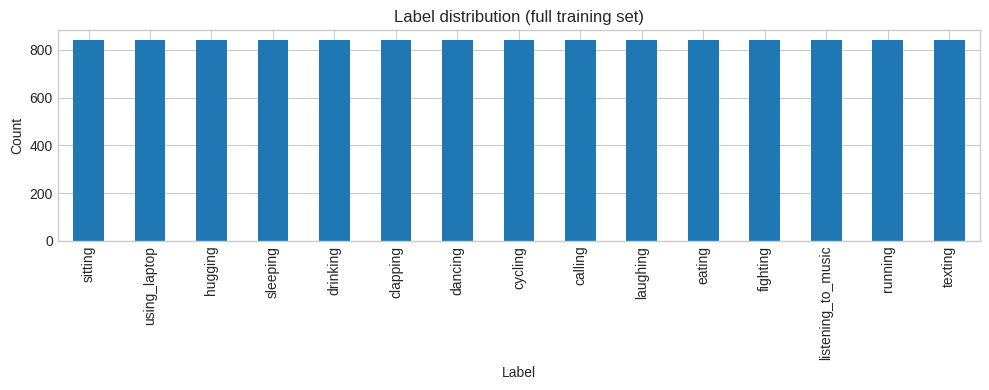

In [7]:
label_counts_full = train_df["label"].value_counts().sort_values(ascending=False)
label_counts_full.plot(kind="bar", figsize=(10, 4))
plt.title("Label distribution (full training set)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


ResNet50 Train and validation

In [8]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 10  # adjust as needed

num_classes = train_df["label_idx"].nunique()

# ================================
# 3) Build tf.data pipelines
# ================================
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = preprocess_input(img)  # ResNet50 preprocessing
    return img, label

# Convert filepaths and labels to tensors
train_paths = train_split["filepath"].astype(str).values
train_labels = train_split["label_idx"].values

val_paths = val_split["filepath"].astype(str).values
val_labels = val_split["label_idx"].values

train_ds = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .shuffle(buffer_size=len(train_paths))
    .map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((val_paths, val_labels))
    .map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# ================================
# 4) Define ResNet50 model
# ================================
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)

# Freeze base model for initial training
base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

# ================================
# 5) Train (frozen backbone)
# ================================
early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

checkpoint = callbacks.ModelCheckpoint(
    "resnet50_best.keras",
    monitor="val_loss",
    save_best_only=True,
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint],
)

# ================================
# 6) Optional: fine-tune top layers
# ================================
# Unfreeze some of the deeper layers of ResNet50
fine_tune_at = 140  # layer index to start unfreezing from (tune if needed)
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

fine_tune_epochs = 5  # extra epochs for fine-tuning

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    callbacks=[early_stop, checkpoint],
)

# ================================
# 7) Final validation metrics
# ================================
val_loss, val_acc = model.evaluate(val_ds)
print(f"Final validation loss: {val_loss:.4f}")
print(f"Final validation accuracy: {val_acc:.4f}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        30,735 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,618,447 (90.10 MB)

 Trainable params: 30,735 (120.06 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 61s 146ms/step - accuracy: 0.4121 - loss: 1.9558 - val_accuracy: 0.6448 - val_loss: 1.1186
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - accuracy: 0.6655 - loss: 1.0662 - val_accuracy: 0.6726 - val_loss: 1.0431
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - accuracy: 0.7001 - loss: 0.9369 - val_accuracy: 0.6952 - val_loss: 0.9735
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.7286 - loss: 0.8328 - val_accuracy: 0.6794 - val_loss: 1.0401
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 36s 115ms/step - accuracy: 0.7284 - loss: 0.8159 - val_accuracy: 0.6964 - val_loss: 0.9773
Epoch 6/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 42s 119ms/step - accuracy: 0.7394 - loss: 0.7879 - val_accuracy: 0.6944 - val_loss: 0.9667
Epoch 7/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 37s 116ms/step - accuracy: 0.7587 - loss: 0.7437 - val_accuracy: 0.6964 - val_loss: 1.0083
Epoch 8/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.7543 - loss: 0

## Test-time predictions
Generate predictions on the held-out test split using the saved ResNet50 model.

In [10]:
# Build inference dataset and generate predictions on the unlabeled test split
def load_and_preprocess_infer(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = preprocess_input(img)
    return img

idx_to_label = {idx: cls for idx, cls in enumerate(label_encoder.classes_)}

test_paths = test_df['filepath'].astype(str).values
test_ds = (
    tf.data.Dataset.from_tensor_slices(test_paths)
    .map(load_and_preprocess_infer, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

loaded_model = tf.keras.models.load_model('resnet50_best.keras')
probs = loaded_model.predict(test_ds)
pred_idx = probs.argmax(axis=1)

test_predictions = test_df.copy()
test_predictions['pred_label'] = [idx_to_label[i] for i in pred_idx]
test_predictions['pred_confidence'] = probs.max(axis=1)

display(test_predictions.head(15))
# Optional: save predictions for external use
# test_predictions[['filename', 'pred_label']].to_csv('predictions.csv', index=False)


169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step


,filename,filepath,pred_label,pred_confidence
0,Image_1.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,sleeping,0.910553
1,Image_2.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,eating,0.997521
2,Image_3.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,running,0.894632
3,Image_4.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,eating,0.751132
4,Image_5.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,listening_to_music,0.261040
5,Image_6.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,clapping,0.999669
6,Image_7.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,fighting,0.522708
7,Image_8.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,hugging,0.424151
8,Image_9.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,laughing,0.930512
9,Image_10.jpg,/root/.cache/kagglehub/datasets/meetnagadia/hu...,drinking,0.991264
